# Hyperparameter Tuning
In this notebook we use bayesian optimisation to tune the hyperparameters for the gradient boosting model.
This notebook is adapted from this [notebook](https://github.com/WillKoehrsen/hyperparameter-optimization/blob/master/Bayesian%20Hyperparameter%20Optimization%20of%20Gradient%20Boosting%20Machine.ipynb)


In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import os
import pickle
from timeit import default_timer as timer
from datetime import date, datetime, timezone
from dateutil.relativedelta import relativedelta
from dateutil import parser
import traceback

from dogs import modelling

In [2]:
DATA_DIR = '../data'

In [3]:
# read data
modelling_data = pd.read_csv(os.path.join(DATA_DIR, 'modelling_data_25days.csv'), index_col = 'race_id')
modelling_data

,date_time,winning_box,benchmark,min_time_1,min_time_2,min_time_3,min_time_4,min_time_5,min_time_6,avg_time_1,...,pcnt_place_3,pcnt_place_4,pcnt_place_5,pcnt_place_6,pcnt_show_1,pcnt_show_2,pcnt_show_3,pcnt_show_4,pcnt_show_5,pcnt_show_6
race_id,,,,,,,,,,,,,,,,,,,,,
2539774,2008-11-15 20:58:00+00:00,5,2,29.08,28.95,29.13,28.89,28.76,29.74,29.176667,...,0.5,0.500000,1.0,0.000000,0.666667,1.000000,0.500000,0.500000,1.0,0.000000
2539775,2008-11-15 21:14:00+00:00,2,1,29.11,29.10,29.25,29.13,29.10,29.02,29.120000,...,0.0,0.500000,0.0,0.333333,0.333333,1.000000,0.666667,0.500000,0.0,0.666667
2851623,2010-08-30 10:07:00+00:00,4,5,30.02,29.95,30.74,30.23,29.84,29.78,30.415000,...,0.0,0.000000,0.5,0.333333,0.500000,0.000000,0.000000,0.000000,0.5,1.000000
2851624,2010-08-30 10:23:00+00:00,3,4,29.99,30.11,30.11,29.53,29.71,29.71,30.117500,...,0.0,0.666667,1.0,0.666667,0.000000,0.000000,0.000000,0.666667,1.0,0.666667
2539777,2008-11-15 21:45:00+00:00,0,1,NaN,NaN,31.08,NaN,30.32,29.47,NaN,...,0.0,NaN,0.0,1.000000,NaN,NaN,0.000000,NaN,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539765,2008-11-15 18:38:00+00:00,0,5,28.85,29.00,29.13,29.10,29.50,28.87,28.865000,...,0.5,0.500000,0.0,0.333333,1.000000,0.666667,0.500000,0.750000,0.0,0.333333
2539766,2008-11-15 18:56:00+00:00,3,2,28.89,29.44,29.55,29.43,29.67,29.04,29.193333,...,0.0,0.000000,0.0,0.500000,1.000000,0.000000,0.000000,0.000000,0.0,0.500000
2539767,2008-11-15 19:11:00+00:00,5,5,29.65,29.71,30.10,29.52,29.95,29.56,29.890000,...,0.5,0.500000,0.0,0.333333,0.333333,0.500000,0.750000,0.500000,0.0,0.666667


## Default Parameters

In [4]:
results = {}
results['default'] = modelling(modelling_data, method = 'default', training_months = 150)

data starts at 2002-01-03 18:09:00+00:00
Building model for 2018:1
Train shape:  (26593, 48)
Test shape:  (282, 48)
The following columns will be used in the modelling 
 ['min_time_1' 'min_time_2' 'min_time_3' 'min_time_4' 'min_time_5'
 'min_time_6' 'avg_time_1' 'avg_time_2' 'avg_time_3' 'avg_time_4'
 'avg_time_5' 'avg_time_6' 'min_stime_1' 'min_stime_2' 'min_stime_3'
 'min_stime_4' 'min_stime_5' 'min_stime_6' 'avg_stime_1' 'avg_stime_2'
 'avg_stime_3' 'avg_stime_4' 'avg_stime_5' 'avg_stime_6' 'avg_fin_1'
 'avg_fin_2' 'avg_fin_3' 'avg_fin_4' 'avg_fin_5' 'avg_fin_6' 'pcnt_win_1'
 'pcnt_win_2' 'pcnt_win_3' 'pcnt_win_4' 'pcnt_win_5' 'pcnt_win_6'
 'pcnt_place_1' 'pcnt_place_2' 'pcnt_place_3' 'pcnt_place_4'
 'pcnt_place_5' 'pcnt_place_6' 'pcnt_show_1' 'pcnt_show_2' 'pcnt_show_3'
 'pcnt_show_4' 'pcnt_show_5' 'pcnt_show_6']
Model correct: 0.188 Benchmark correct 0.287
Building model for 2018:2
Train shape:  (26676, 48)
Test shape:  (222, 48)
The following columns will be used in the modelling

perform_modelling encountered an error for 2018: 10
Building model for 2018:11
Train shape:  (26956, 48)
Test shape:  (208, 48)
The following columns will be used in the modelling 
 ['min_time_1' 'min_time_2' 'min_time_3' 'min_time_4' 'min_time_5'
 'min_time_6' 'avg_time_1' 'avg_time_2' 'avg_time_3' 'avg_time_4'
 'avg_time_5' 'avg_time_6' 'min_stime_1' 'min_stime_2' 'min_stime_3'
 'min_stime_4' 'min_stime_5' 'min_stime_6' 'avg_stime_1' 'avg_stime_2'
 'avg_stime_3' 'avg_stime_4' 'avg_stime_5' 'avg_stime_6' 'avg_fin_1'
 'avg_fin_2' 'avg_fin_3' 'avg_fin_4' 'avg_fin_5' 'avg_fin_6' 'pcnt_win_1'
 'pcnt_win_2' 'pcnt_win_3' 'pcnt_win_4' 'pcnt_win_5' 'pcnt_win_6'
 'pcnt_place_1' 'pcnt_place_2' 'pcnt_place_3' 'pcnt_place_4'
 'pcnt_place_5' 'pcnt_place_6' 'pcnt_show_1' 'pcnt_show_2' 'pcnt_show_3'
 'pcnt_show_4' 'pcnt_show_5' 'pcnt_show_6']


Traceback (most recent call last):
  File "/home/d14xj1/repos/dogs/dogs/modelling/modelling.py", line 142, in modelling
    predictions = model.predict_proba(X_test)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/sklearn.py", line 863, in predict_proba
    pred_leaf, pred_contrib, **kwargs)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/sklearn.py", line 665, in predict
    pred_leaf=pred_leaf, pred_contrib=pred_contrib, **kwargs)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/basic.py", line 2415, in predict
    data_has_header, is_reshape)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/basic.py", line 504, in predict
    data = _data_from_pandas(data, None, None, self.pandas_categorical)[0]
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/basic.py", line 315, in _data_from_pandas
    raise ValueError('Input data must be 2 dimensional and non empty.')
ValueError: Input data

Model correct: 0.202 Benchmark correct 0.332
Building model for 2018:12
Train shape:  (26966, 48)
Test shape:  (209, 48)
The following columns will be used in the modelling 
 ['min_time_1' 'min_time_2' 'min_time_3' 'min_time_4' 'min_time_5'
 'min_time_6' 'avg_time_1' 'avg_time_2' 'avg_time_3' 'avg_time_4'
 'avg_time_5' 'avg_time_6' 'min_stime_1' 'min_stime_2' 'min_stime_3'
 'min_stime_4' 'min_stime_5' 'min_stime_6' 'avg_stime_1' 'avg_stime_2'
 'avg_stime_3' 'avg_stime_4' 'avg_stime_5' 'avg_stime_6' 'avg_fin_1'
 'avg_fin_2' 'avg_fin_3' 'avg_fin_4' 'avg_fin_5' 'avg_fin_6' 'pcnt_win_1'
 'pcnt_win_2' 'pcnt_win_3' 'pcnt_win_4' 'pcnt_win_5' 'pcnt_win_6'
 'pcnt_place_1' 'pcnt_place_2' 'pcnt_place_3' 'pcnt_place_4'
 'pcnt_place_5' 'pcnt_place_6' 'pcnt_show_1' 'pcnt_show_2' 'pcnt_show_3'
 'pcnt_show_4' 'pcnt_show_5' 'pcnt_show_6']
Model correct: 0.196 Benchmark correct 0.287
                   test_date  model_accuracy  benchmark_accuracy  \
0  2018-01-01 00:00:00+00:00        0.187943         

With the default parameters the model scores an overall accuracy of 18.1% compared to the benchmark of 27.4%.

## Cross Validation with early stopping

In [5]:
results['cv'] = modelling(modelling_data, method = 'cv', nfold = 3, training_months = 150)

data starts at 2002-01-03 18:09:00+00:00
Building model for 2018:1
Train shape:  (26593, 48)
Test shape:  (282, 48)
The following columns will be used in the modelling 
 ['min_time_1' 'min_time_2' 'min_time_3' 'min_time_4' 'min_time_5'
 'min_time_6' 'avg_time_1' 'avg_time_2' 'avg_time_3' 'avg_time_4'
 'avg_time_5' 'avg_time_6' 'min_stime_1' 'min_stime_2' 'min_stime_3'
 'min_stime_4' 'min_stime_5' 'min_stime_6' 'avg_stime_1' 'avg_stime_2'
 'avg_stime_3' 'avg_stime_4' 'avg_stime_5' 'avg_stime_6' 'avg_fin_1'
 'avg_fin_2' 'avg_fin_3' 'avg_fin_4' 'avg_fin_5' 'avg_fin_6' 'pcnt_win_1'
 'pcnt_win_2' 'pcnt_win_3' 'pcnt_win_4' 'pcnt_win_5' 'pcnt_win_6'
 'pcnt_place_1' 'pcnt_place_2' 'pcnt_place_3' 'pcnt_place_4'
 'pcnt_place_5' 'pcnt_place_6' 'pcnt_show_1' 'pcnt_show_2' 'pcnt_show_3'
 'pcnt_show_4' 'pcnt_show_5' 'pcnt_show_6']
[1]	cv_agg's accuracy: 0.183018 + 0.000791651
[2]	cv_agg's accuracy: 0.186966 + 0.00202919
[3]	cv_agg's accuracy: 0.192118 + 0.00127939
[4]	cv_agg's accuracy: 0.194788 + 0

[30]	cv_agg's accuracy: 0.20247 + 0.00115043
[31]	cv_agg's accuracy: 0.203144 + 0.0016493
[32]	cv_agg's accuracy: 0.203518 + 0.00198415
[33]	cv_agg's accuracy: 0.202283 + 0.000961611
[34]	cv_agg's accuracy: 0.20247 + 0.00216078
[35]	cv_agg's accuracy: 0.201759 + 0.00235845
[36]	cv_agg's accuracy: 0.201647 + 0.00285587
[37]	cv_agg's accuracy: 0.200711 + 0.00299875
[38]	cv_agg's accuracy: 0.200674 + 0.00391001
[39]	cv_agg's accuracy: 0.200824 + 0.00425125
[40]	cv_agg's accuracy: 0.200412 + 0.00365256
[41]	cv_agg's accuracy: 0.199364 + 0.00415154
[42]	cv_agg's accuracy: 0.20015 + 0.00376915
[43]	cv_agg's accuracy: 0.200636 + 0.00385316
[44]	cv_agg's accuracy: 0.200824 + 0.0041909
[45]	cv_agg's accuracy: 0.201273 + 0.00451695
[46]	cv_agg's accuracy: 0.201198 + 0.00443584
[47]	cv_agg's accuracy: 0.200674 + 0.00477756
[48]	cv_agg's accuracy: 0.199439 + 0.00465313
[49]	cv_agg's accuracy: 0.199439 + 0.00417605
[50]	cv_agg's accuracy: 0.199401 + 0.00434815
[51]	cv_agg's accuracy: 0.198653 + 0.0

[22]	cv_agg's accuracy: 0.205196 + 0.00110236
[23]	cv_agg's accuracy: 0.205568 + 0.000730501
[24]	cv_agg's accuracy: 0.206051 + 0.00127454
[25]	cv_agg's accuracy: 0.207537 + 0.00160089
[26]	cv_agg's accuracy: 0.206868 + 0.00146853
[27]	cv_agg's accuracy: 0.207314 + 0.00107956
[28]	cv_agg's accuracy: 0.207835 + 0.00204107
[29]	cv_agg's accuracy: 0.207314 + 0.0022954
[30]	cv_agg's accuracy: 0.206943 + 0.00231435
[31]	cv_agg's accuracy: 0.206868 + 0.00295546
[32]	cv_agg's accuracy: 0.205902 + 0.00185708
[33]	cv_agg's accuracy: 0.206645 + 0.00126997
[34]	cv_agg's accuracy: 0.206459 + 0.0013888
[35]	cv_agg's accuracy: 0.20553 + 0.00245122
[36]	cv_agg's accuracy: 0.204341 + 0.00168545
[37]	cv_agg's accuracy: 0.20501 + 0.00210912
[38]	cv_agg's accuracy: 0.204861 + 0.00244923
[39]	cv_agg's accuracy: 0.203969 + 0.00235403
[40]	cv_agg's accuracy: 0.204118 + 0.00219087
[41]	cv_agg's accuracy: 0.204601 + 0.00224687
[42]	cv_agg's accuracy: 0.204713 + 0.00181698
[43]	cv_agg's accuracy: 0.204192 + 0.

[2]	cv_agg's accuracy: 0.187258 + 0.00236415
[3]	cv_agg's accuracy: 0.194677 + 0.00237081
[4]	cv_agg's accuracy: 0.195932 + 0.00199182
[5]	cv_agg's accuracy: 0.200177 + 0.000367068
[6]	cv_agg's accuracy: 0.200694 + 0.00159148
[7]	cv_agg's accuracy: 0.201248 + 0.00182458
[8]	cv_agg's accuracy: 0.201764 + 0.00186868
[9]	cv_agg's accuracy: 0.200399 + 0.00150293
[10]	cv_agg's accuracy: 0.200989 + 0.00180844
[11]	cv_agg's accuracy: 0.202097 + 0.00178388
[12]	cv_agg's accuracy: 0.202761 + 0.00253569
[13]	cv_agg's accuracy: 0.203352 + 0.00337793
[14]	cv_agg's accuracy: 0.204496 + 0.0011463
[15]	cv_agg's accuracy: 0.205087 + 0.000716838
[16]	cv_agg's accuracy: 0.203795 + 0.00144968
[17]	cv_agg's accuracy: 0.205197 + 0.0036295
[18]	cv_agg's accuracy: 0.203536 + 0.0039032
[19]	cv_agg's accuracy: 0.203573 + 0.004207
[20]	cv_agg's accuracy: 0.20409 + 0.00300875
[21]	cv_agg's accuracy: 0.204607 + 0.00245426
[22]	cv_agg's accuracy: 0.205345 + 0.00299464
[23]	cv_agg's accuracy: 0.206785 + 0.00180594


Traceback (most recent call last):
  File "/home/d14xj1/repos/dogs/dogs/modelling/modelling.py", line 142, in modelling
    predictions = model.predict_proba(X_test)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/sklearn.py", line 863, in predict_proba
    pred_leaf, pred_contrib, **kwargs)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/sklearn.py", line 665, in predict
    pred_leaf=pred_leaf, pred_contrib=pred_contrib, **kwargs)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/basic.py", line 2415, in predict
    data_has_header, is_reshape)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/basic.py", line 504, in predict
    data = _data_from_pandas(data, None, None, self.pandas_categorical)[0]
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/basic.py", line 315, in _data_from_pandas
    raise ValueError('Input data must be 2 dimensional and non empty.')
ValueError: Input data

[2]	cv_agg's accuracy: 0.187083 + 0.00393919
[3]	cv_agg's accuracy: 0.187676 + 0.00360039
[4]	cv_agg's accuracy: 0.19313 + 0.00200574
[5]	cv_agg's accuracy: 0.195764 + 0.0020643
[6]	cv_agg's accuracy: 0.197693 + 0.0016989
[7]	cv_agg's accuracy: 0.197544 + 0.00140652
[8]	cv_agg's accuracy: 0.19747 + 0.0033644
[9]	cv_agg's accuracy: 0.200772 + 0.00517642
[10]	cv_agg's accuracy: 0.201699 + 0.00548798
[11]	cv_agg's accuracy: 0.201736 + 0.00534569
[12]	cv_agg's accuracy: 0.203406 + 0.00495164
[13]	cv_agg's accuracy: 0.203035 + 0.00479275
[14]	cv_agg's accuracy: 0.202886 + 0.00378279
[15]	cv_agg's accuracy: 0.203294 + 0.00378569
[16]	cv_agg's accuracy: 0.203554 + 0.00366753
[17]	cv_agg's accuracy: 0.202478 + 0.00224113
[18]	cv_agg's accuracy: 0.202256 + 0.00226055
[19]	cv_agg's accuracy: 0.203109 + 0.00119324
[20]	cv_agg's accuracy: 0.203146 + 0.00248861
[21]	cv_agg's accuracy: 0.202107 + 0.00283841
[22]	cv_agg's accuracy: 0.201885 + 0.0018175
[23]	cv_agg's accuracy: 0.202219 + 0.00308222
[2

In [6]:
pd.DataFrame.from_dict(results, orient = 'index', columns = ['Model', 'Benchmark', 'Races', 'Features', 'Training_Time'])

,Model,Benchmark,Races,Features,Training_Time
default,0.180514,0.274169,2648,"min_stime, pcnt_place, min_time, pcnt_show, pc...",23.376610
cv,0.195242,0.274169,2648,"min_stime, pcnt_place, min_time, pcnt_show, pc...",45.151169


Using cross validation to identify the optimal number of boosting iterations gives us a slight boost in validation accuracy

## Hyperparameter tuning using Bayesian Optimisation

In [7]:
results['tune'] = modelling(modelling_data, method = 'tune', nfold = 3, training_months = 150, max_evals = 200)

data starts at 2002-01-03 18:09:00+00:00
Building model for 2018:1
Train shape:  (26593, 48)
Test shape:  (282, 48)
The following columns will be used in the modelling 
 ['min_time_1' 'min_time_2' 'min_time_3' 'min_time_4' 'min_time_5'
 'min_time_6' 'avg_time_1' 'avg_time_2' 'avg_time_3' 'avg_time_4'
 'avg_time_5' 'avg_time_6' 'min_stime_1' 'min_stime_2' 'min_stime_3'
 'min_stime_4' 'min_stime_5' 'min_stime_6' 'avg_stime_1' 'avg_stime_2'
 'avg_stime_3' 'avg_stime_4' 'avg_stime_5' 'avg_stime_6' 'avg_fin_1'
 'avg_fin_2' 'avg_fin_3' 'avg_fin_4' 'avg_fin_5' 'avg_fin_6' 'pcnt_win_1'
 'pcnt_win_2' 'pcnt_win_3' 'pcnt_win_4' 'pcnt_win_5' 'pcnt_win_6'
 'pcnt_place_1' 'pcnt_place_2' 'pcnt_place_3' 'pcnt_place_4'
 'pcnt_place_5' 'pcnt_place_6' 'pcnt_show_1' 'pcnt_show_2' 'pcnt_show_3'
 'pcnt_show_4' 'pcnt_show_5' 'pcnt_show_6']
100%|██████████| 200/200 [13:12<00:00,  3.96s/trial, best loss: 0.785319368003676] 
The best hyperparms are
{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsampl

100%|██████████| 200/200 [15:52<00:00,  4.76s/trial, best loss: 0.7859472204730567]
The best hyperparms are
{'boosting_type': 'goss', 'class_weight': 'balanced', 'colsample_bytree': 0.866769813604307, 'learning_rate': 0.015387980554457711, 'min_child_samples': 435, 'num_leaves': 58, 'reg_alpha': 0.7673954182020695, 'reg_lambda': 0.6647901537089208, 'subsample_for_bin': 300000, 'subsample': 1.0, 'num_class': 6, 'objective': 'multiclass'}
Model correct: 0.156 Benchmark correct 0.244
Building model for 2018:8
Train shape:  (27038, 48)
Test shape:  (215, 48)
The following columns will be used in the modelling 
 ['min_time_1' 'min_time_2' 'min_time_3' 'min_time_4' 'min_time_5'
 'min_time_6' 'avg_time_1' 'avg_time_2' 'avg_time_3' 'avg_time_4'
 'avg_time_5' 'avg_time_6' 'min_stime_1' 'min_stime_2' 'min_stime_3'
 'min_stime_4' 'min_stime_5' 'min_stime_6' 'avg_stime_1' 'avg_stime_2'
 'avg_stime_3' 'avg_stime_4' 'avg_stime_5' 'avg_stime_6' 'avg_fin_1'
 'avg_fin_2' 'avg_fin_3' 'avg_fin_4' 'avg_fi

Traceback (most recent call last):
  File "/home/d14xj1/repos/dogs/dogs/modelling/modelling.py", line 142, in modelling
    predictions = model.predict_proba(X_test)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/sklearn.py", line 863, in predict_proba
    pred_leaf, pred_contrib, **kwargs)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/sklearn.py", line 665, in predict
    pred_leaf=pred_leaf, pred_contrib=pred_contrib, **kwargs)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/basic.py", line 2415, in predict
    data_has_header, is_reshape)
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/basic.py", line 504, in predict
    data = _data_from_pandas(data, None, None, self.pandas_categorical)[0]
  File "/home/d14xj1/.venvs/dogs/lib/python3.6/site-packages/lightgbm/basic.py", line 315, in _data_from_pandas
    raise ValueError('Input data must be 2 dimensional and non empty.')
ValueError: Input data

100%|██████████| 200/200 [12:59<00:00,  3.90s/trial, best loss: 0.786540959054054]
The best hyperparms are
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.7856050020661284, 'learning_rate': 0.08269505045952408, 'min_child_samples': 480, 'num_leaves': 33, 'reg_alpha': 0.8398830119506808, 'reg_lambda': 0.8751118984907046, 'subsample_for_bin': 140000, 'subsample': 0.8464190415736506, 'num_class': 6, 'objective': 'multiclass'}
Model correct: 0.216 Benchmark correct 0.332
Building model for 2018:12
Train shape:  (26966, 48)
Test shape:  (209, 48)
The following columns will be used in the modelling 
 ['min_time_1' 'min_time_2' 'min_time_3' 'min_time_4' 'min_time_5'
 'min_time_6' 'avg_time_1' 'avg_time_2' 'avg_time_3' 'avg_time_4'
 'avg_time_5' 'avg_time_6' 'min_stime_1' 'min_stime_2' 'min_stime_3'
 'min_stime_4' 'min_stime_5' 'min_stime_6' 'avg_stime_1' 'avg_stime_2'
 'avg_stime_3' 'avg_stime_4' 'avg_stime_5' 'avg_stime_6' 'avg_fin_1'
 'avg_fin_2' 'avg_fin_3' 'avg_fin_4

In [20]:
results_df = pd.DataFrame.from_dict(results, orient = 'index', columns = ['Model Accuracy', 'Benchmark', 'Races', 'Features', 'Training Time (s)'])
results_df.drop('Features', axis = 1)

,Model Accuracy,Benchmark,Races,Training Time (s)
default,0.180514,0.274169,2648,23.376610
cv,0.195242,0.274169,2648,45.151169
tune,0.198263,0.274169,2648,9556.515193


<AxesSubplot:>

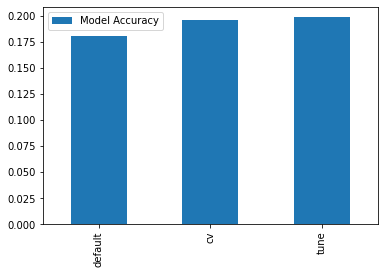

In [18]:
results_df.plot(y = 'Model Accuracy', kind = 'bar')

<AxesSubplot:>

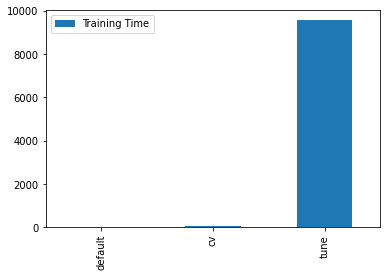

In [19]:
results_df.plot(y = 'Training Time', kind = 'bar')